In [1]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
import os, random
import time
from PIL import Image
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import cv2
import timm
from sklearn.metrics import accuracy_score

# Loading model

In [14]:
model_names = timm.list_models(pretrained=True)
print(model_names)

['adv_inception_v3', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dla34', 'dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2', 'dla169', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnetlight', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b2a', 'efficientnet_b3', 'efficientnet_b3_pruned', 'efficientnet_b3a', 'efficientnet_em', 'efficientnet_es', 'efficientnet_lite0', 'ens_adv_inception_resnet_v2', 'ese_vovnet19b_dw', 'ese_vovnet39b', 'fbnetc_100', 'gluon_inception_v3', 'gluon_resnet18_v1b', 'gluon_resnet34_v1b', 'gluon_resnet50_v1b', 'gluon_resnet50_v1c', 'gluon_resnet50_v1d', 'gluon_resnet50_v1s', 'gluon_resnet101_v1b', 'gluon_resnet101_v1c', 'gluon_resnet101_v1d

In [2]:
#using resnets I have to use more LR
#TIMM_MODEL = 'resnest50d'
TIMM_MODEL = 'efficientnet_b2'
class CassavaNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = timm.create_model(TIMM_MODEL, pretrained=True)
        #n_features = backbone.fc.in_features #resnet/resnest
        n_features = backbone.classifier.in_features #efficentnet
        self.backbone = nn.Sequential(*backbone.children())[:-2]
        self.classifier = nn.Linear(n_features, 5)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.pool(feats).view(x.size(0), -1)
        x = self.classifier(x)
        return x, feats

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
from pytorch_model_summary import summary
print(summary(CassavaNet(), show_input=True))

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSep

TypeError: forward() missing 1 required positional argument: 'x'

# Train

In [3]:
class CassavaDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, root_dir, transforms=None):

        super().__init__()
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)
    
    def get_img_bgr_to_rgb(self, path):
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        return im_rgb

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = self.get_img_bgr_to_rgb(img_name)
        if self.transforms:
            image = self.transforms(image=image)['image']
        csv_row = self.dataframe.iloc[idx, 1:]
        sample = {
            'image': image, 
            'label': csv_row.label,
        }
        return sample

In [4]:
DATA_PATH = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
NUM_FOLDS = 5
bs = 3
# Running only 5 epochs to test (Train more offline ^_^)
EPOCHS = 2
sz = 512
GRAD_ACCUM_STEPS = 1

def train_transforms():
    return Compose([
            A.RandomResizedCrop(sz, sz),
            #A.Transpose(p=0.5),
            A.Rotate (limit=10),
            A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


def valid_transforms():
    return Compose([
            A.Resize(sz, sz),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 1234
seed_everything(SEED)   

In [6]:
def accuracy_metric(input, targs):
    return accuracy_score(targs.cpu(), input.cpu())

def print_scores(scores):
    kaggle_metric = np.average(scores)
    print("Kaggle Metric: %f" % (kaggle_metric))
    
    return kaggle_metric

In [7]:
def checkpoint(model, optimizer, epoch, current_metric, best_metric, fold):
    print("Metric improved from %f to %f , Saving Model at Epoch #%d" % (best_metric, current_metric, epoch))
    ckpt = {
        'model': CassavaNet(),
        'state_dict': model.state_dict(),
        #'optimizer' : optimizer.state_dict(),  # Commenting this out to cheap out on space
        'metric': current_metric
    }
    torch.save(ckpt, '/media/sergio/traballos sergio/msi/models/cassava/ckpt_%s-%d-%d-no.pth' % (TIMM_MODEL, sz, fold))

In [8]:
train_df = pd.read_csv(DATA_PATH + "train.csv")

In [9]:
folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, 
                        random_state=SEED).split(np.arange(train_df.shape[0]), 
                                                 train_df.label.values)

In [10]:
for fold_num, (train_split, valid_split) in enumerate(folds):
    train_set = train_df.iloc[train_split].reset_index(drop=True)
    valid_set = train_df.iloc[valid_split].reset_index(drop=True)
    
    train_ds = CassavaDataset(dataframe=train_set,
                          root_dir=DATA_PATH + 'train_images',
                          transforms=train_transforms())
    
    valid_ds = CassavaDataset(dataframe=valid_set,
                          root_dir=DATA_PATH + 'train_images',
                          transforms=valid_transforms())
    
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, 
                                           shuffle=True, num_workers=8, drop_last=True,
                                           pin_memory=True)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, 
                                           shuffle=False, num_workers=8, 
                                           pin_memory=True)
    
    losses = []
    batches = len(train_dl)
    val_batches = len(valid_dl)
    best_metric = 0
    
    model = CassavaNet().to(device)
    criterion = nn.CrossEntropyLoss(reduction='none').to(device)
    val_criterion = nn.CrossEntropyLoss().to(device)
    param_groups = [
       {'params': model.backbone.parameters(), 'lr': 1e-1},
       {'params': model.classifier.parameters()},
    ]
    optimizer = torch.optim.SGD(param_groups, lr=1, momentum=0.9,
                                weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,20,40], 
                                                     gamma=0.1, last_epoch=-1, verbose=True)
    scaler = GradScaler()
    
    for epoch in range(EPOCHS):
        # ----------------- TRAINING  ----------------- 
        train_loss = 0
        progress = tqdm(enumerate(train_dl), desc="Loss: ", total=batches)

        model.train()
        for i, data in progress:
            image, label = data.values()
            X, y = image.to(device).float(), label.to(device).long()
            
            outputs, _ = model(X)
            loss = torch.mean(criterion(outputs, y))
                
            scaler.scale(loss).backward()
            # Accumulate gradients
            if ((i + 1) % GRAD_ACCUM_STEPS == 0) or ((i + 1) == len(train_dl)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            train_loss += loss.item()
            cur_step = i+1
            trn_epoch_result = dict()
            trn_epoch_result['Epoch'] = epoch + 1
            trn_epoch_result['train_loss'] = round(train_loss/cur_step, 4)

            progress.set_description(str(trn_epoch_result))

        scheduler.step()
        #if torch.cuda.is_available():
        torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        val_loss = 0
        scores = []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_dl):
                image, label = data.values()
                X, y = image.to(device), label.to(device)
                outputs, _ = model(X)
                l = val_criterion(outputs, y)
                val_loss += l.item()

                preds = F.softmax(outputs).argmax(axis=1)
                scores.append(accuracy_metric(preds, y))

        epoch_result = dict()
        epoch_result['Epoch'] = epoch + 1
        epoch_result['train_loss'] = round(train_loss/batches, 4)
        epoch_result['val_loss'] = round(val_loss/val_batches, 4)

        print(epoch_result)

        # Check if we need to save
        current_metric = print_scores(scores)
        if current_metric > best_metric:
            checkpoint(model, optimizer, epoch+1, current_metric, best_metric, fold_num)
            best_metric = current_metric
            
    del model, optimizer, train_dl, valid_dl, scaler, scheduler
    torch.cuda.empty_cache()
    
    # Train only a single fold
    #break

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 1 to 1.0000e+00.


{'Epoch': 1, 'train_loss': 2.0772}: 100%|██████████| 5705/5705 [16:31<00:00,  5.76it/s] 

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 1 to 1.0000e-01.



<ipython-input-10-6ff7c93540f7>:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(outputs).argmax(axis=1)


{'Epoch': 1, 'train_loss': 2.0772, 'val_loss': 1.9622}
Kaggle Metric: 0.119248
Metric improved from 0.000000 to 0.119248 , Saving Model at Epoch #1


{'Epoch': 2, 'train_loss': 1.1421}: 100%|██████████| 5705/5705 [15:32<00:00,  6.12it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 1 to 1.0000e-01.


{'Epoch': 2, 'train_loss': 1.1421, 'val_loss': 2.3411}
Kaggle Metric: 0.595538
Metric improved from 0.119248 to 0.595538 , Saving Model at Epoch #2
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 1 to 1.0000e+00.


{'Epoch': 1, 'train_loss': 57.342}:   0%|          | 28/5705 [00:04<16:38,  5.68it/s] 


KeyboardInterrupt: 

# Results

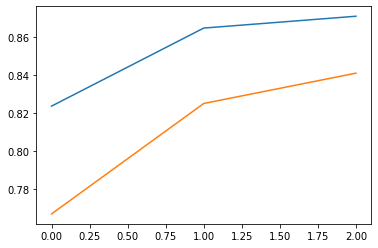

In [13]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

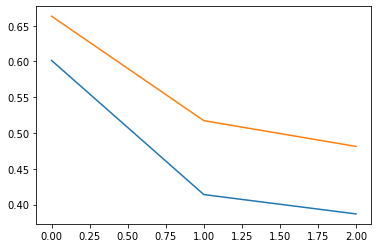

In [14]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [10]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2.h5'
torch.save(model, PATH)

In [ ]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2-best.h5'
torch.save(best_model, PATH)

In [19]:
model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
images: 1000
0 Loss: 0.4861 Acc: 0.8330
1 Loss: 0.3932 Acc: 0.8623

Epoch 1/1
----------
images: 1000
0 Loss: 0.4753 Acc: 0.8360
1 Loss: 0.4009 Acc: 0.8617

Training complete in 27m 41s
Best val Acc: 0.862305
train loss: [0.4860530502452251, 0.47531284963301507]

val loss: [0.3931747988661362, 0.4008864563196387]

train acc: [0.8329576070819816, 0.8359817452026173]

val acc: [0.8623052959501558, 0.8616822429906542]


# Semi-train 

In [4]:
#Data transformations for data augmentation
jitter_param = 0.3
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-30,30), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values

train_val_split = 0.85
batch_size = 6

train_dataset = Dataset(imgs[0:700], 
                        labels[0:700], 
                        train_transform)
val_dataset = Dataset(imgs[1000:1500], 
                      labels[1000:1500], 
                      val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.75)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
0 Loss: 1.4239 Acc: 0.4914
1 Loss: 1.1418 Acc: 0.6260

Epoch 1/4
----------
0 Loss: 1.2096 Acc: 0.5743
1 Loss: 1.0764 Acc: 0.6260

Epoch 2/4
----------
0 Loss: 1.1282 Acc: 0.5800
1 Loss: 1.0208 Acc: 0.6500

Epoch 3/4
----------


KeyboardInterrupt: 

In [ ]:
last acc: [0.87507] resnet